Nesse tutorial, vamos implementar uma rede neural profunda usando TensorFlow. Partindo da teoria do [tutorial de introdução às redes neurais](https://matheusfacure.github.io/2017/03/05/ann-intro/) e do que ensinei no [tutorial de TensorFlow essencial](https://matheusfacure.github.io/2017/05/12/tensorflow-essencial/), vamos criar uma rede neural para classificar imagens de dígitos escritos à mão. Nesse caso, os dados são imagens em preto e branco
de dígitos desenhados. A dimensão da imagem é 28 por 28 pixeis, o que nos dá 784 variáveis. Os nossos alvos ou classes são vetores *one-hot* com zeros em todas as casas menos na do dígito em questão. Por exemplo, o dígito 7 é representado por um vetor de zeros com 1 na oitava casa `[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]`.

Extracting tmp/train-images-idx3-ubyte.gz
Extracting tmp/train-labels-idx1-ubyte.gz
Extracting tmp/t10k-images-idx3-ubyte.gz
Extracting tmp/t10k-labels-idx1-ubyte.gz


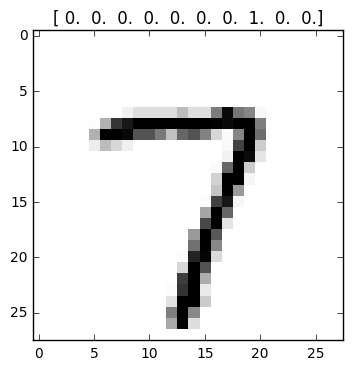

In [1]:
import numpy as np # para computação numérica menos intensiva
import os # para criar pastas
from matplotlib import pyplot as plt # para mostrar imagens
import tensorflow as tf # para redes neurais

# criamos uma pasta para colocar os dados
if not os.path.exists('tmp'):
    os.makedirs('tmp')

# baixa os dados na pasta criada 
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("tmp/", one_hot=True) # carrega os dados já formatados

# mostra a centésima imagem no set de treino
plt.imshow(data.train.images[100].reshape(28,28), cmap='Greys', interpolation='nearest')
plt.title(str(data.train.labels[100])) # vetor one-hot que representa o dígito
plt.show()

## Recapitulando
Nós vimos no [tutorial teórico](https://matheusfacure.github.io/2017/03/05/ann-intro/) de redes neurais que um modelo de rede neural artificial pode ser tão simples quanto 

$$ \phi(\phi(\pmb{X} \pmb{W_1})\pmb{W_2}) \pmb{w} = \pmb{y} $$

Aqui, vamos considerar uma pequena modificação na formulação:

$$ \phi(\phi(\pmb{X} \pmb{W_1} + \pmb{b_1})\pmb{W_2} + \pmb{b_2}) \pmb{w} + \pmb{b} = \pmb{y} $$

Essa formulação é menos concisa mas representa o mesmo modelo. Na primeira formulação, precisamos colocar nos dados uma coluna de $\pmb{1}$ para calcular os diversos $\pmb{b}$s (relembre isso no [tutorial de regressão linear](https://matheusfacure.github.io/2017/02/15/MQO-formula-analitica/)). Aqui, como cada cada camada tem seu próprio $\pmb{b}$, é mais conveniente explicitá-los como na segunda formulação. Apenas para irmos nos acostumando com a nomenclatura, lembre-se de que os $\pmb{b}$s são chamados de intercepto nos modelos lineares, mas nas redes neurais, nos referimos a eles como vieses (*biases*, do inglês).

Vamos relembrar o que acontece no modelo definido acima. Em primeiro lugar, nós multiplicamos os dados por uma grande matriz de parâmetros, aos que chamamos pesos (*weight*). Nós então adicionamos os vieses (*bias*) após essa multiplicação de matriz: $\pmb{X} \pmb{W_1} + \pmb{b_1}$. Isso é uma típica transformação linear onde usamos operações de multiplicação e adição. Após essa transformação linear, nós passamos seu resultado por alguma função não linear $\phi$, como a [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks). Isso resultará no output da primeira camada, $\pmb{X}^*$. Nós podemos tratamos esse output como o input da segunda camada, e aplicamos nele uma nova transformação linear, seguida de alguma não linearidade para obter o output da segunda camada, $\pmb{X}^{**}$. Podemos repedir isso por quantas camadas quisermos, mas nesse caso, paramos por aqui e passamos $\pmb{X}^{**}$ como as variáveis de algum modelo linear, como uma regressão logística.

Para implementar esse modelo, vamos considerar o código desenvolvido no [tutorial de TensorFlow](https://matheusfacure.github.io/2017/05/12/tensorflow-essencial/) e fazer algumas pequenas alterações. Como ponto de partida, sugiro que você simplesmente copie e cole o código de lá.

## Fase de Construção do Grafo
Novamente, começamos definindo algumas constantes, dentre elas, os hiper-parâmetros do nosso modelo de rede neural. Depois, partimos para a construção de um grafo TensorFlow. No grafo, primeiro adicionamos as variáveis das matrizes de parâmetros $\pmb{W}$. Em vez de concatenarmos uma uma coluna de $\pmb{1}$ aos inputs de cada camada, vamos adicionar um vetor de vieses $\pmb{b}$. Uma vez criadas as variáveis, vamos encadear transformações lineares com não linearidades por duas camadas. Por fim, passamos o output da segunda camada para um modelo de regressão logística, ao qual chamaremos de camada de output. Como esse é um problema de classificação, vamos utilizar a função custo de entropia cruzada, que será minimizada com gradiente descendente.

In [2]:
# definindo constantes
lr = 0.01 # taxa de aprendizado
n_iter = 4000 # número de iterações de treino
batch_size = 128 # qtd de imagens no mini-lote (para GDE)
n_inputs = 28 * 28 # número de variáveis (píxeis)
n_l1 = 512 # número de neurônios da primeira camada
n_l2 = 512 # número de neurônios da segunda camada
n_outputs = 10 # número classes (dígitos)

graph = tf.Graph() # cria um grafo
with graph.as_default(): # abre o grafo para colocar nós
    
    # adiciona as variáveis da primeira camada ao grafo
    W1 = tf.Variable(tf.truncated_normal([n_inputs, n_l1]), name='Weight_1')
    b1 = tf.Variable(tf.zeros([n_l1]), name='bias_1')
    
    # adiciona as variáveis da segunda camada ao grafo
    W2 = tf.Variable(tf.truncated_normal([n_l1, n_l2]), name='Weight_2')
    b2 = tf.Variable(tf.zeros([n_l2]), name='bias_2')
    
    # adiciona as variáveis da camada de saída (ou modelo linear) grafo
    Wo = tf.Variable(tf.truncated_normal([n_l2, n_outputs]), name='Weight_o')
    bo = tf.Variable(tf.zeros([n_outputs]), name='bias_o')

    ############################################
    # Monta o modelo de rede neural artificial #
    ############################################

    # Camadas de Inputs
    x_input = tf.placeholder(tf.float32, [None, n_inputs], name='X_input')
    y_input = tf.placeholder(tf.float32, [None, n_outputs], name='y_input')

    # Camada 1
    l1 = tf.nn.relu(tf.matmul(x_input, W1) + b1, name='layer_1')
    
    # Camada 2
    l2 = tf.nn.relu(tf.matmul(l1, W2) + b2, name='layer_2')

    # Camada de output
    logits = tf.add(tf.matmul(l2, Wo), bo, name='output_layer')
    y_hat = tf.nn.softmax(logits) # converte scorer em probabilidades
    
    # função objetivo
    error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_input, logits=logits, name='error'))
    
    # otimizador
    optimizer = tf.train.AdamOptimizer(lr).minimize(error)

    # inicializador
    init = tf.global_variables_initializer()

    # para salvar o modelo treinado
    saver = tf.train.Saver()


Tensor("Mean:0", shape=(), dtype=float32)


Vamos agora, parte por parte entender o que foi feito acima. Dentro do grafo, primeiro definimos as variáveis. `W1` são os pesos da primeira camada. No nosso modelo, nós vamos multiplicar os dados com essa matriz, por isso ela tem o mesmo número de linhas que o número de variáveis nos dados. Além disso, o número de colunas dessa matriz definirá o número de neurônios da primeira camada da rede neural. Seja $z_1$ os neurônios da primeira camada, temos:

$$
\phi \Bigg( \quad
\begin{bmatrix}
x_{11} & ... & x_{1d} \\
x_{21} & ... & x_{2d} \\
\vdots & \vdots& \vdots & \vdots \\
x_{n1} & ... & x_{nd} \\
\end{bmatrix}
\times
\begin{bmatrix}
w_{11} & ... & w_{1m} \\
w_{21} & ... & w_{2m} \\
\vdots & \vdots& \vdots & \vdots \\
w_{d1} & ... & w_{dm} \\
\end{bmatrix}
+
\begin{bmatrix}
b_{1} \\
b_{2} \\
\vdots \\
b_{d} \\
\end{bmatrix} \quad \Bigg)
=
\begin{bmatrix}
z_{11} \\
z_{12} \\
\vdots \\
z_{1n} \\
\end{bmatrix}$$

Se você lembrar do [algoritmo de regressão linear](https://matheusfacure.github.io/2017/02/15/MQO-formula-analitica/), poderá perceber que, antes da não linearidade, a **multiplicação da matriz de dados por uma coluna da matriz de parâmetros é exatamente uma regressão linear**. Assim, vemos que **uma rede neural nada mais é do que várias regressões lineares seguidas de não linearidades**. É simples assim, por isso estou enfatizando isso. A próxima camada é análoga a primeira: nós multiplicamos inputs por uma matriz de parâmetros `W2`, adicionamos `b2` e aplicamos a não linearidade ReLU. As únicas diferenças entre a primeira e a segunda camada é que (1) agora o input não são mais os dados, mas os outputs da primeira camada, e que (2) a quantidade de neurônios (colunas de `W2`) é diferente. Como a atividade nos neurônios da primeira camada serão os inputs da segunda camada, a matriz de parâmetros dessa camada, `W2`, terá o mesmo número de linhas que os a quantidade de neurônios da primeira camada; o número de colunas de `W2` definirá a quantidade de neurônios da segunda camada. Finalmente, nós passamos o output da segunda camada para um modelo linear, nesse caso, uma regressão logística. Para isso, primeiro usamos uma transformação linear: `tf.add(tf.matmul(l2, Wo), bo, name='output_layer')`. Essa operação gera uma pontuação para cada classe/dígito, que geralmente é chamada de *logit*. Note que não usamos a não linearidade aqui. Em vez disso, passamos os *logits* direto para uma função de achatamento softmax, que converte a pontuação em uma probabilidade válida (às vezes chamada *probit*), isto é, de forma que a soma da probabilidade de cada dígito resulte em 1. Isso conclui nosso modelo.

A seguir, nós definimos a função custo com `tf.nn.softmax_cross_entropy_with_logits()`. Essa função com um nome enorme faz duas coisas. Primeiro, converte os *logits* em probabilidades aplicando a função softmax e depois compara a previsão com o a classe real e retorna a função custo de entropia cruzada. Mas por que usar de novo a função softmax se já havíamos feito isso antes? Fazemos isso por simples estabilidade computacional. Usar entropia cruzada seguido de softmax podem resultar em números com muitas casas decimais ou muito grandes, coisas que um computador não consegue representar bem. O TensorFlow tem então essa função `tf.nn.softmax_cross_entropy_with_logits()` para realizar de forma estável uma tranformação softmax seguida do cálculo da entropia cruzada. Tome **muito cuidado** para não passar o tensor `y_hat` de probabilidades para `tf.nn.softmax_cross_entropy_with_logits()`. `y_hat` Já passou pela função softmax e passar esse tensor de novo por ela é problemático. A rede neural ainda irá treinar sem problemas, mas a performance será drasticamente reduzida e a convergência tomará muito mais tempo. Por isso, é difícil pegar esse *bug* e acabamos pensando que o modelo não é bom, quando na verdade erramos na especificação da função custo.

O resto do grafo não é novo. Novamente, nós criamos um otimizador para minimizar o erro, um nó para inicializar as variáveis e um *saver* para salvar o modelo treinado.

## Fase de execução

A faze de execução pode ser reutilizada do [tutorial de TensorFlow](https://matheusfacure.github.io/2017/05/12/tensorflow-essencial/) quase sem alteração. Como essa base de dados é muito grande, nós precisamos usar gradiente descendente estocástico (GDE) em vez de gradiente descendente normal. A diferença é explicada [neste tutorial](https://matheusfacure.github.io/2017/02/20/MQO-Gradiente-Descendente/#Gradiente-descendente-estocástico), mas, em poucas palavras, gradiente descendente realiza iterações mais precisas, o tempo de cada iteração aumenta com o tamanho da base de dados, tornando-se proibitivo para bases grades demais. Por outro lado, o tempo de uma iteração de treinamento de GDE **não** aumenta com o tamanho da base de dados, mas com o tamanho de um mini-lote de dados (que definimos acima). O preço que pagamos é um iteração menos precisa quanto menor for o mini-lote. Na pratica, a convergência é muito mais rápida com GDE.

Nós também vamos calcular a acurácia de validação de tempos em tempos (1000 iterações). Para isso, é útil definir uma função que calcula a acurácia a partir do vetor de probabilidade de cada dígito. Para isso, vamos achar qual a posição de maior probabilidade no vetor. Isso nos dará o dígito previsto. Depois vamos comparar os dígitos previstos com os verdadeiros. Nós tiramos a média dos acerto e multiplicamos por 100 para ter a percentagem de acertos. Também salvaremos os parâmetros do modelo  cada 1000 iterações.

In [3]:
def accuracy(pred_y, true_y):
    '''Compara dois vetores one-hot para produzir a acurácia'''

    pred_labels = np.argmax(pred_y, 1) # acha o dígito de maior prob. prevista
    true_labels = np.argmax(true_y, 1) # acha o dígito verdadeiro
    
    return (pred_labels == true_labels).mean() * 100 # compara ambos


# abrimos a sessão tf
with tf.Session(graph=graph) as sess:
    init.run() # iniciamos as variáveis
    
    # loop de treinamento
    for step in range(n_iter+1):

        # cria os mini-lotes
        x_batch, y_batch = data.train.next_batch(batch_size)

        # cria um feed_dict
        feed_dict = {x_input: x_batch, y_input: y_batch}

        # executa uma iteração de treino e calcula o erro
        l, _ = sess.run([error, optimizer], feed_dict=feed_dict)
            
        # mostra o progresso a cada 1000 iterações
        if step % 1000 == 0:
            
            x_valid, y_valid = data.validation.next_batch(512) # pega alguns dados de validação
            val_dict = {x_input: x_valid, y_input: y_valid} # monta o feed_dict
            error_np, probs = sess.run([error, y_hat], feed_dict=val_dict) # calcula probabilidades e erro 
            
            print('Erro de treino na iteração %d: %.2f' % (step, l))
            print('Erro de validação na iteração %d: %.2f' % (step, error_np))
            print('Acurácia de validação na iteração %d: %.2f\n' % (step, accuracy(probs, y_valid)))

            saver.save(sess, "./tmp/deep_ann.ckpt")

Erro de treino na iteração 0: 2903.53
Erro de validação na iteração 0: 1940.68
Acurácia de validação na iteração 0: 11.52

Erro de treino na iteração 1000: 12.85
Erro de validação na iteração 1000: 6.11
Acurácia de validação na iteração 1000: 97.46

Erro de treino na iteração 2000: 3.83
Erro de validação na iteração 2000: 12.35
Acurácia de validação na iteração 2000: 95.31

Erro de treino na iteração 3000: 6.29
Erro de validação na iteração 3000: 6.11
Acurácia de validação na iteração 3000: 97.85

Erro de treino na iteração 4000: 1.32
Erro de validação na iteração 4000: 8.18
Acurácia de validação na iteração 4000: 96.88



Para calcular a acurácia, usamos `np.argmax()`, primeiro convertemos os vetores de probabilidades e o vetor *one-hot* nos dígitos que eles representam. Por exemplo, no caso do vetor que representa um 7 (`[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]`), `np.argmax()` retorna `7`, já que essa é a posição do maior número do vetor.  Outro detalhe importante é passar como segundo argumento para `np.argmax()` a dimensão para computar o máximo. No nosso caso, temos uma matriz de vetores de probabilidade empilhados. Essa matriz é do formato `[n_observações, n_digitos]` e nós queremos o máximo relativo a segunda dimensão. Assim, passamos `1` (a segunda dimensão, lembre-se de que a contagem começa em 0) para `np.argmax()` e obtemos um vetor com os dígitos previstos, no formato `[n_observações, 1]`.

Quanto a fase de execução em sí, a única novidade quanto ao [tutorial passado](https://matheusfacure.github.io/2017/05/12/tensorflow-essencial/) é que não passamos todos os dados para uma iteração de otimização, mas apenas um mini-lote de dados. Por conveniência, o TensorFlow envolveu os dados em um objeto que tem um método `.train.next_batch()` que nos dá o próximo mini-lote nos dados. Em outros casos, nós precisamos montar os mini-lotes na mão, mas isso é bastante simples (você pode conferir como fazer isso no [exercício que propus](https://github.com/matheusfacure/Tutoriais-de-AM/blob/master/Redes%20Neurais%20Artificiais/Tutorial%20de%20TensorFlow.ipynb) no tutorial de [TensorFlow Essencial](https://matheusfacure.github.io/2017/05/12/tensorflow-essencial/).

Com esse código e algumas poucas (4000) iterações de treino já conseguimos prever com mais de 96% de acurácia (de validção), qual dígito está representado em cada imagem (os resultados podem variar um pouco a cada execução do programa). Isso pode parecer bom, mas na verdade é uma performance bem irrisória para uma rede neural, nessa base de dados. Mais para frente, vamos ver como melhorar esses resultados.

Antes de prosseguir, vale a pena chamar a atenção para alguns **erros e bug comuns** que podem aparecer. Em primeiro lugar, note como chamamos de `error_np` o erro de validação calculado a cada 1000 iterações. Fizemos isso pois a variável `error` já se referia ao nó de entropia cruzada no grafo TensorFlow. Usar a mesma variável em Python para se referir a essas duas coisas resultará em erros nem sempre fáceis de entender, por isso tome cuidado com o nome das suas variáveis! Um outro erro comum é passar dados no formato diferente dos *placeholders*. Para resolver isso, eu recomendo sempre verificar o formato dos dados com algo como `print(x_batch.shape)`.

Agora que temos nosso modelo treinado e salvo, podemos restaurá-lo para fazer previsões. A seguir, vamos avaliar a performance da nossa rede neural em 5000 exemplos do set de teste. Se seu computado tem RAM o suficiente, sinta-se a vontade para usar o set de teste todo para avaliação.

In [4]:
# novamente, abrimos a sessão tf
with tf.Session(graph=graph) as sess:
    
    # restauramos o valor das variáveis 
    saver.restore(sess, "./tmp/deep_ann.ckpt", )
    
    x_test, y_test = data.test.next_batch(5000)
    
    # rodamos o nó de previsão no grafo
    feed_dict = {x_input: x_test}
    probs = y_hat.eval(feed_dict={x_input: x_test}) # calcula as probabilidades
    
    print('\nAcurácia de teste: %.2f' % accuracy(probs, y_test))


INFO:tensorflow:Restoring parameters from ./tmp/deep_ann.ckpt

Acurácia de teste: 97.12


Tudo o que fizemos acima parece muito coisa, mas fizemos apenas poucas mudanças no código desenvolvido no tutorial de [TensorFlow Essencial](https://matheusfacure.github.io/2017/05/12/tensorflow-essencial/). Para entender melhor o que fizemos, eu **recomendo fortemente** que você copie o código de lá e tente modificá-lo para rodar essa rede neural.

## Simplificando o código TensorFlow

O programa desenvolvido usa as funcionalidades de mais baixo nível do TensorFlow e tem a vantagem de ser extremamente flexível. No entanto, quando só queremos montar uma simples rede neural profunda, o método que vimos é desnecessariamente longo. Por exemplo, por que precisamos definir as variáveis de cada camada?? Não parece óbvio que ao criar uma camada da rede neural as variáveis já deveriam ser criadas junto?? Felizmente, o TensorFlow dispõe de uma função que serve exatamente para isso: `tf.contrib.layers.fully_connected()`. É só passar para essa função os dados de entrada, a quantidade de neurônios e pronto, a mágica acontece. 

In [16]:
from tensorflow.contrib.layers import fully_connected

new_graph = tf.Graph()
with new_graph.as_default():
    
    # Camadas de Inputs
    x_input = tf.placeholder(tf.float32, [None, n_inputs], name='X_input')
    y_input = tf.placeholder(tf.float32, [None, n_outputs], name='y_input')
    
    l1 = fully_connected(x_input, n_l1, scope="layer_1") # camada 1
    l2 = fully_connected(l1, n_l2, scope="layer_2") # camada 2
    
    # camada de saída
    logits = fully_connected(l2, n_outputs, activation_fn=None, scope="output_layer")
    y_hat = tf.nn.softmax(logits) # converte scorer em probabilidades
    
    # erro
    error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_input, logits=logits, name='error'))
    
    # otimizador
    optimizer = tf.train.AdamOptimizer(lr).minimize(error)

    # inicializador
    init = tf.global_variables_initializer()

    # para salvar o modelo treinado
    saver = tf.train.Saver()

Como padrão, a função de ativação de `fully_connected()` é a ReLU, por isso, só alteramos esse argumento na camada de saída, onde não queremos nenhuma função de ativação. A função `fully_connected()` facilita muito na implementação de redes neurais. Com ela, não precisamos definir variáveis e o código fica bem mais limpo. Além disso, várias funcionalidades estão implementadas em `fully_connected()`, como formas melhores de inicializar os parâmetros, regularização, e normalização. Isso talvez não faça muito sentido ainda, mas mais para frente veremos como melhorar a convergência das redes neurais com essas ferramentas. Eu recomendo fortemente que você leia a [documentação de `fully_connected()`](`fully_connected()`).

A fase de execução desse do grafo simplificado acima é exatamente a mesma que mostramos antes. Você pode simplesmente copiar e tudo funcionará exatamente como antes. Só tome cuidado para mudar o nome do grafo que usaremos na sessão com `with tf.Session(graph=new_graph) as sess:`.

In [17]:
# calcula quantas iterações de treino por época
def accuracy(pred_y, true_y):
    '''Compara dois vetores one-hot para produzir a acurácia'''

    pred_labels = np.argmax(pred_y, 1) # acha o dígito de maior prob. prevista
    true_labels = np.argmax(true_y, 1) # acha o dígito verdadeiro
    
    return (pred_labels == true_labels).mean() * 100 # compara ambos


# abrimos a sessão tf
with tf.Session(graph=new_graph) as sess:
    init.run() # iniciamos as variáveis
    
    # loop de treinamento
    for step in range(n_iter+1):

        # cria os mini-lotes
        x_batch, y_batch = data.train.next_batch(batch_size)

        # cria um feed_dict
        feed_dict = {x_input: x_batch, y_input: y_batch}

        # executa uma iteração de treino e calcula o erro
        l, _ = sess.run([error, optimizer], feed_dict=feed_dict)
            
        # mostra o progresso a cada 1000 iterações
        if step % 1000 == 0:
            
            x_valid, y_valid = data.validation.next_batch(512) # pega alguns dados de validação
            val_dict = {x_input: x_valid, y_input: y_valid} # monta o feed_dict
            error_np, probs = sess.run([error, y_hat], feed_dict=val_dict) # calcula probabilidades e erro 
            
            print('Erro de treino na iteração %d: %.2f' % (step, l))
            print('Erro de validação na iteração %d: %.2f' % (step, error_np))
            print('Acurácia de validação na iteração %d: %.2f\n' % (step, accuracy(probs, y_valid)))

            saver.save(sess, "./tmp/deep_ann.ckpt")

Erro de treino na iteração 0: 2.27
Erro de validação na iteração 0: 3.07
Acurácia de validação na iteração 0: 42.77

Erro de treino na iteração 1000: 0.24
Erro de validação na iteração 1000: 0.09
Acurácia de validação na iteração 1000: 96.48

Erro de treino na iteração 2000: 0.06
Erro de validação na iteração 2000: 0.13
Acurácia de validação na iteração 2000: 96.88

Erro de treino na iteração 3000: 0.06
Erro de validação na iteração 3000: 0.05
Acurácia de validação na iteração 3000: 98.44

Erro de treino na iteração 4000: 0.03
Erro de validação na iteração 4000: 0.18
Acurácia de validação na iteração 4000: 97.85



No caso de redes neurais tão simples como essa nossa, podemos simplificar ainda mais

In [37]:
from sklearn.metrics import accuracy_score

data = input_data.read_data_sets("tmp/", one_hot=False) # carrega os dados já formatados

x_input = tf.contrib.learn.infer_real_valued_columns_from_input(data.train.images)

deep_ann = tf.contrib.learn.DNNClassifier(hidden_units = [n_l1, n_l2], # qtd de neurônios por camada
                                         feature_columns = x_input, # var. independentes
                                         n_classes = n_outputs, # número de classes (10)
                                         activation_fn = tf.nn.relu, # função de ativação das camadas
                                         optimizer = tf.train.AdamOptimizer(learning_rate=lr)) # otimizador 

deep_ann.fit(x=data.train.images.astype(np.float32), # conversão de tipo
            y=data.train.labels.astype(np.int64), # conversão de tipo
            batch_size=128, # tamanho do mini-lote
            steps=4000) # iterações de treino

deep_ann.evaluate(data.test.images.astype(np.float32), # variáveis independentes
                  data.test.labels.astype(np.int64)) # variáveis dependentes

Extracting tmp/train-images-idx3-ubyte.gz
Extracting tmp/train-labels-idx1-ubyte.gz
Extracting tmp/t10k-images-idx3-ubyte.gz
Extracting tmp/t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': None, '_is_chief': True, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_environment': 'local', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5351c21908>, '_num_worker_replicas': 0, '_save_summary_steps': 100, '_master': '', '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_keep_checkpoint_max': 5, '_num_ps_replicas': 0, '_task_type': None, '_tf_random_seed': None, '_task_id': 0, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000}
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_f

/usr/local/lib/python3.5/dist-packages/tensorflow/python/util/deprecation.py:248: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpilauguh9/model.ckpt.
INFO:tensorflow:loss = 2.35878, step = 1
INFO:tensorflow:global_step/sec: 37.0067
INFO:tensorflow:loss = 0.19755, step = 101 (2.704 sec)
INFO:tensorflow:global_step/sec: 44.6967
INFO:tensorflow:loss = 0.111026, step = 201 (2.237 sec)
INFO:tensorflow:global_step/sec: 44.9511
INFO:tensorflow:loss = 0.0797299, step = 301 (2.224 sec)
INFO:tensorflow:global_step/sec: 44.814
INFO:tensorflow:loss = 0.160103, step = 401 (2.231 sec)
INFO:tensorflow:global_step/sec: 44.7418
INFO:tensorflow:loss = 0.17806, step = 501 (2.235 sec)
INFO:tensorflow:global_step/sec: 44.7872
INFO:tensorflow:loss = 0.0803717, step = 601 (2.234 sec)
INFO:tensorflow:global_step/sec: 44.3077
INFO:tensorflow:loss = 0.0935697, step = 701 (2.256 sec)
INFO:tensorflow:global_step/sec: 44.4244
INFO:tensorflow:loss = 0.289389, step = 801 (2.251 sec)
INFO:tensorflow:global_step/sec: 44.9141
INFO:tensorflow:loss = 0.104132, step = 901 (2.226 sec)
INFO:tensor

{'accuracy': 0.96710002, 'global_step': 4000, 'loss': 0.15508126}

Ok... Esse código é extremamente abstrato. Em construímos uma rede neural em uma linha em outra, a treinamos. Vamos linha por linha detalhar o que está acontecendo. Nós primeiro definimos os inputs com `tf.contrib.learn.infer_real_valued_columns_from_input()`. O argumento dessa função são os dados de treino com as variáveis independentes. Nesse caso, `data.train.images`. Em seguida, criamos um classificador com `tf.contrib.learn.DNNClassifier()`, que é um envólucro de alto nível para abstrair todo o processo complicado de construção de uma rede neural. Os argumentos são autoexplicativos. Depois usamos o método `.fit()` desse classificador. A única complicação aqui é reformatar os dados. Como variável independente, `.fit()` aceita apenas o tipo numérico `float32`. As variáveis dependentes $y$ devem ser do tipo `float64`, por isso realizamos essas conversões. Além disso, a variável dependente $y$ não pode ser um vetor *one-hot*, mas um vetor de **índices representado classes**. Por isso, recarregamos os dados usando agora `one_hot=False`. No treinamento, usamos mini-lotes de com 128 amostrar e treinamos o modelo por 4000 iterações. Finalmente, usamos passamos ao método `.evaluate()` os dados e as classes de teste para avaliar o modelo. 

Uma aviso final que precisa ser dado é que o módulo `contrib` é um lugar de experimentação e pode mudar drasticamente de versão para versão do TensorFlow. Eu particularmente não gosto muito desse módulo. Ele abstrai muito do controle que gosto de ter ao construir as redes neurais. Porém, para aplicações bem simples, acredito que ele possa ser útil.